In [1]:
import pandas as pd
import numpy as np
#import tensorflow.compat.v1 as tf
import tensorflow as tf
from tqdm import tqdm
from utils import *
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import silhouette_score, davies_bouldin_score
## imputations
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # Needed to import IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.mixture import GaussianMixture
from sklearn.impute import SimpleImputer
import fancyimpute
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("cleaned_data_with_latlong.csv")

In [3]:
df.head()

,REGION,PROV_CODE,PROV_NAME,DIST_CODE,DIST_NAME,INC_DATE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Season,Latitude,Longitude
0,Eastern,7,Laghman,701,Mehtarlam,2016-01-31,Flood / flash flood,0,0,62,10,8,2,Winter,34.666954,70.071718
1,North Eastern,15,Badakhshan,1504,Arghanjkhwa,2016-02-13,Avalanche,3,0,21,3,0,0,Winter,37.366577,70.970672
2,Central Highland,22,Daykundi,2207,Sang-e-Takht,2016-03-07,Flood / flash flood,10,1,19,8,0,5,Spring,34.178306,65.860740
3,Northern,18,Balkh,1803,Shortepa,2016-03-10,Flood / flash flood,0,0,1533,219,0,219,Spring,37.213477,66.832580
4,Western,31,Farah,3101,Farah,2016-03-11,Flood / flash flood,18,9,996,150,88,32,Spring,32.234080,62.222932


In [4]:
dataset = df.copy()

In [5]:
df.describe()

,PROV_CODE,DIST_CODE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
count,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000,2589.000000
mean,14.321360,1438.291232,0.929703,1.415218,361.327153,52.451139,31.086906,15.151796,34.707445,68.831875
std,8.416575,841.343008,18.556810,31.123331,1684.494835,241.358164,142.317297,115.014217,1.249136,2.544037
min,1.000000,101.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.853347,61.053751
25%,7.000000,703.000000,0.000000,0.000000,21.000000,3.000000,1.000000,0.000000,34.163208,67.640391
50%,13.000000,1306.000000,0.000000,0.000000,70.000000,10.000000,6.000000,0.000000,34.745481,69.697367
75%,19.000000,1902.000000,0.000000,0.000000,210.000000,30.000000,19.000000,3.000000,35.108166,70.728239
max,34.000000,3405.000000,860.000000,1193.000000,41034.000000,5913.000000,3674.000000,3752.000000,38.444539,71.508298


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2589 entries, 0 to 2588
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   REGION                2589 non-null   object 
 1   PROV_CODE             2589 non-null   int64  
 2   PROV_NAME             2589 non-null   object 
 3   DIST_CODE             2589 non-null   int64  
 4   DIST_NAME             2589 non-null   object 
 5   INC_DATE              2589 non-null   object 
 6   INC_TYPE              2589 non-null   object 
 7   Persons_killed        2589 non-null   int64  
 8   Persons_injured       2589 non-null   int64  
 9   Individuals_affected  2589 non-null   int64  
 10  Families_affected     2589 non-null   int64  
 11  Houses_damaged        2589 non-null   int64  
 12  Houses_destroyed      2589 non-null   int64  
 13  Season                2589 non-null   object 
 14  Latitude              2589 non-null   float64
 15  Longitude            

In [7]:
df.isna().sum()

REGION                  0
PROV_CODE               0
PROV_NAME               0
DIST_CODE               0
DIST_NAME               0
INC_DATE                0
INC_TYPE                0
Persons_killed          0
Persons_injured         0
Individuals_affected    0
Families_affected       0
Houses_damaged          0
Houses_destroyed        0
Season                  0
Latitude                0
Longitude               0
dtype: int64

In [8]:
#new_data_cleaned = new_data.drop(columns=['PROV_NAME', 'DIST_NAME', 'INC_DATE', 'PROV_CODE', 'DIST_CODE'])
df_cleaned = df.drop(columns=['PROV_NAME', 'DIST_NAME', 'INC_DATE'])

# Encoding categorical columns: 'REGION', 'INC_TYPE', and 'Season'
label_encoder = LabelEncoder()
df_cleaned['REGION'] = label_encoder.fit_transform(df_cleaned['REGION'])
df_cleaned['INC_TYPE'] = label_encoder.fit_transform(df_cleaned['INC_TYPE'])
df_cleaned['Season'] = label_encoder.fit_transform(df_cleaned['Season'])

# Using 'Season' as the label
X_features_season = df_cleaned.drop(columns=['Season'])  # Drop 'Season' from features
y_labels_season = df_cleaned['Season']  # 'Season' is the label

# Standardizing the dataset
scaler = StandardScaler()
X_scaled_features_season = scaler.fit_transform(X_features_season)



/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

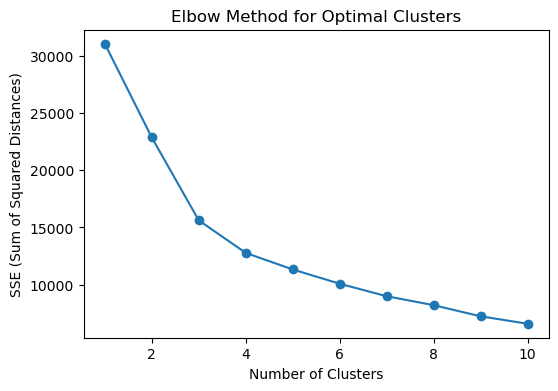

In [103]:
# Creating Elbow plot for finding optimal K
sse = []
cluster_range = range(1, 11)  # Testing clusters from 1 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_features_season)
    ## Inertia: Sum of squared distances to nearest cluster center
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(cluster_range, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [10]:
# K-means clustering with 4 clusters (for 'Season')
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(X_scaled_features_season)

# Calculate the silhouette score for clustering
silhouette_avg_fixed_season = silhouette_score(X_scaled_features_season, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_fixed_season}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.4890701931290923


In [11]:
#Calculate the Davies-Bouldin score for clustering
db_index = davies_bouldin_score(X_scaled_features_season, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 0.858870467855995


In [12]:
data = X_features_season.copy()

# MCAR

In [13]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [14]:
# Convert DataFrame to NumPy array
data_array = data.to_numpy()

# Now call the function with the NumPy array
data_MCAR = produce_NA(data_array, p_miss=0.25, mecha="MCAR")

# convert it back to a DataFrame after processing
data_MCAR_df = pd.DataFrame(data_MCAR['X_incomp'], columns=data.columns)

In [15]:
data_MCAR_df.head()

,REGION,PROV_CODE,DIST_CODE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
0,2.0,7.0,701.0,2.0,0.0,0.0,NaN,NaN,8.0,2.0,34.666954,70.071716
1,3.0,15.0,NaN,0.0,3.0,0.0,21.0,3.0,NaN,NaN,37.366577,70.970673
2,1.0,22.0,2207.0,2.0,NaN,1.0,19.0,8.0,NaN,5.0,34.178307,65.860741
3,4.0,NaN,NaN,2.0,0.0,NaN,NaN,219.0,0.0,219.0,37.213478,66.832581
4,NaN,NaN,3101.0,NaN,18.0,9.0,996.0,150.0,88.0,32.0,32.234081,62.222931


In [16]:
data.shape

(2589, 12)

In [104]:
#count of missing values
data_MCAR_df.isna().sum()

REGION                  634
PROV_CODE               655
DIST_CODE               617
INC_TYPE                678
Persons_killed          684
Persons_injured         655
Individuals_affected    661
Families_affected       642
Houses_damaged          690
Houses_destroyed        648
Latitude                646
Longitude               646
dtype: int64

Text(0.5, 1.0, 'Missing Data Patterns (Original)')

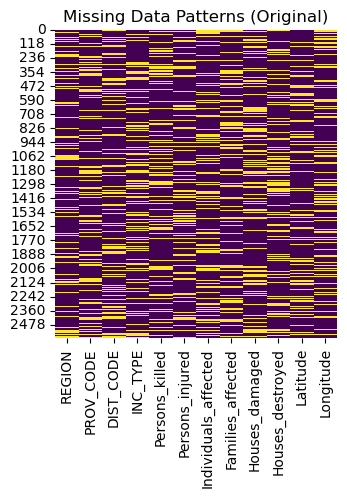

In [18]:
#visualise missing values
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(data_MCAR_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Patterns (Original)')

In [19]:
#percentage of missing values
print("Percentage of newly generated missing values: ", (data_MCAR['mask'].sum()).numpy()/np.prod(data_MCAR['mask'].size())*100, " %")

Percentage of newly generated missing values:  25.286468391914514  %


In [20]:
data_MCAR_DL = data_MCAR_df.copy()

# Simple Imputation

In [21]:
data_MCAR_df.head()

,REGION,PROV_CODE,DIST_CODE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
0,2.0,7.0,701.0,2.0,0.0,0.0,NaN,NaN,8.0,2.0,34.666954,70.071716
1,3.0,15.0,NaN,0.0,3.0,0.0,21.0,3.0,NaN,NaN,37.366577,70.970673
2,1.0,22.0,2207.0,2.0,NaN,1.0,19.0,8.0,NaN,5.0,34.178307,65.860741
3,4.0,NaN,NaN,2.0,0.0,NaN,NaN,219.0,0.0,219.0,37.213478,66.832581
4,NaN,NaN,3101.0,NaN,18.0,9.0,996.0,150.0,88.0,32.0,32.234081,62.222931


In [22]:
data_MCAR_simple_imput = data_MCAR_df.copy()

In [23]:
data_MCAR_simple_imput.columns

Index(['REGION', 'PROV_CODE', 'DIST_CODE', 'INC_TYPE', 'Persons_killed',
       'Persons_injured', 'Individuals_affected', 'Families_affected',
       'Houses_damaged', 'Houses_destroyed', 'Latitude', 'Longitude'],
      dtype='object')

In [24]:
mean_columns = ['PROV_CODE', 'DIST_CODE','Persons_killed', 'Persons_injured', 'Individuals_affected', 'Families_affected','Houses_damaged', 'Houses_destroyed', 'Latitude', 'Longitude']
column_mean = data_MCAR_simple_imput[mean_columns].mean()

In [25]:
column_mean

PROV_CODE                 14.407963
DIST_CODE               1449.308316
Persons_killed             0.689764
Persons_injured            1.680972
Individuals_affected     366.090249
Families_affected         55.045198
Houses_damaged            33.011058
Houses_destroyed          16.548686
Latitude                  34.701087
Longitude                 68.821825
dtype: float64

In [26]:
mode_columns = ['REGION','INC_TYPE']
column_mode = data_MCAR_simple_imput[mode_columns].mode().iloc[0] 

In [27]:
column_mode

REGION      2.0
INC_TYPE    2.0
Name: 0, dtype: float64

In [28]:
#imputing numerical columns with mean value and categorical with mode value
data_MCAR_simple_imput[mean_columns] = data_MCAR_simple_imput[mean_columns].fillna(column_mean)
data_MCAR_simple_imput[mode_columns] = data_MCAR_simple_imput[mode_columns].fillna(column_mode)

In [29]:
data_MCAR_simple_imput.head()

,REGION,PROV_CODE,DIST_CODE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
0,2.0,7.000000,701.000000,2.0,0.000000,0.000000,366.090249,55.045198,8.000000,2.000000,34.666954,70.071716
1,3.0,15.000000,1449.308316,0.0,3.000000,0.000000,21.000000,3.000000,33.011058,16.548686,37.366577,70.970673
2,1.0,22.000000,2207.000000,2.0,0.689764,1.000000,19.000000,8.000000,33.011058,5.000000,34.178307,65.860741
3,4.0,14.407963,1449.308316,2.0,0.000000,1.680972,366.090249,219.000000,0.000000,219.000000,37.213478,66.832581
4,2.0,14.407963,3101.000000,2.0,18.000000,9.000000,996.000000,150.000000,88.000000,32.000000,32.234081,62.222931


In [30]:
#standardise imputed dataset
scaler = StandardScaler()
X_scaled_simple_impute = scaler.fit_transform(data_MCAR_simple_imput)

In [31]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(X_scaled_simple_impute)

# Calculate the silhouette score for clustering
silhouette_avg_simple_impute = silhouette_score(X_scaled_simple_impute, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_simple_impute}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.44068239833686784


In [32]:
# Calculate the Davies-Bouldin score for clustering
db_index_simple_imput = davies_bouldin_score(X_scaled_simple_impute, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_simple_imput}')

Davies-Bouldin Index: 0.8325337022023832


# KNN

In [33]:
data_MCAR_knn = data_MCAR_df.copy()

In [34]:
data_MCAR_knn.head()

,REGION,PROV_CODE,DIST_CODE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
0,2.0,7.0,701.0,2.0,0.0,0.0,NaN,NaN,8.0,2.0,34.666954,70.071716
1,3.0,15.0,NaN,0.0,3.0,0.0,21.0,3.0,NaN,NaN,37.366577,70.970673
2,1.0,22.0,2207.0,2.0,NaN,1.0,19.0,8.0,NaN,5.0,34.178307,65.860741
3,4.0,NaN,NaN,2.0,0.0,NaN,NaN,219.0,0.0,219.0,37.213478,66.832581
4,NaN,NaN,3101.0,NaN,18.0,9.0,996.0,150.0,88.0,32.0,32.234081,62.222931


In [35]:
data_MCAR_knn.columns

Index(['REGION', 'PROV_CODE', 'DIST_CODE', 'INC_TYPE', 'Persons_killed',
       'Persons_injured', 'Individuals_affected', 'Families_affected',
       'Houses_damaged', 'Houses_destroyed', 'Latitude', 'Longitude'],
      dtype='object')

In [36]:
data_MCAR_knn.isna().sum()

REGION                  634
PROV_CODE               655
DIST_CODE               617
INC_TYPE                678
Persons_killed          684
Persons_injured         655
Individuals_affected    661
Families_affected       642
Houses_damaged          690
Houses_destroyed        648
Latitude                646
Longitude               646
dtype: int64

In [37]:
#evaluate different k values for imputation with clustering
def evaluate_knn_imputation_clustering(k_values, X, n_clusters):
    results = {}
    for k in k_values:
        # Impute missing values using KNNImputer with different k values
        knn_imputer = KNNImputer(n_neighbors=k)
        X_imputed = knn_imputer.fit_transform(X)
        
        # Perform clustering (KMeans in this case)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_imputed)
        cluster_labels = kmeans.labels_
        
        # Evaluate clustering performance using silhouette score
        score = silhouette_score(X_imputed, cluster_labels)
        results[k] = score
    
    return results

k_values = range(3, 15)  # Range of k values for KNNImputer
n_clusters = 4  # Number of clusters to use in KMeans
results = evaluate_knn_imputation_clustering(k_values, data_MCAR_knn, n_clusters)

# best k value for imputation based on silhouette score
best_k = max(results, key=results.get)
print(f'Best k value: {best_k} with silhouette score: {results[best_k]}')


/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

Best k value: 7 with silhouette score: 0.6025452534152168


/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [38]:
# using kNN imputation with best k value
knn_imputer = KNNImputer(n_neighbors=best_k)
X_imputed_best = knn_imputer.fit_transform(data_MCAR_knn)

In [39]:
X_imputed_best.shape

(2589, 12)

In [40]:
#standardise imputed dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_imputed_best)

In [41]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(scaled_features)

# Calculate the silhouette score for clustering
silhouette_avg_knn_impute = silhouette_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_knn_impute}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.474555319067596


In [42]:
# Calculate the Davies-Bouldin score for clustering
db_index_knn_imput = davies_bouldin_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_knn_imput}')

Davies-Bouldin Index: 0.6994789286791719


# MICE

In [43]:
data_MCAR_mice = data_MCAR_df.copy()
data_MCAR_mice.head()

,REGION,PROV_CODE,DIST_CODE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
0,2.0,7.0,701.0,2.0,0.0,0.0,NaN,NaN,8.0,2.0,34.666954,70.071716
1,3.0,15.0,NaN,0.0,3.0,0.0,21.0,3.0,NaN,NaN,37.366577,70.970673
2,1.0,22.0,2207.0,2.0,NaN,1.0,19.0,8.0,NaN,5.0,34.178307,65.860741
3,4.0,NaN,NaN,2.0,0.0,NaN,NaN,219.0,0.0,219.0,37.213478,66.832581
4,NaN,NaN,3101.0,NaN,18.0,9.0,996.0,150.0,88.0,32.0,32.234081,62.222931


In [44]:
#evaluate optimal iterations for mice
def evaluate_mice_imputation_kmeans(max_iter_values, X, n_clusters):
    results_mice = {}
    for max_iter in max_iter_values:
        # Initialize the MICE imputer with different max_iter values
        mice_imputer = IterativeImputer(max_iter=max_iter, random_state=42)
        X_imputed = mice_imputer.fit_transform(X)
        
        # Perform clustering using KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_imputed)
        cluster_labels = kmeans.labels_
        
        # Evaluate clustering performance using silhouette score
        score = silhouette_score(X_imputed, cluster_labels)
        results_mice[max_iter] = score
    
    return results_mice

max_iter_values = range(1, 21)  # Range of max_iter values for MICE imputer
n_clusters = 3  # Number of clusters for KMeans


results_mice = evaluate_mice_imputation_kmeans(max_iter_values, data_MCAR_mice, n_clusters)

# best max_iter value based on silhouette score
best_max_iter = max(results_mice, key=results_mice.get)
print(f'Best max_iter value: {best_max_iter} with silhouette score: {results_mice[best_max_iter]}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-pack

Best max_iter value: 3 with silhouette score: 0.865997798670913


In [45]:
# using mice imputation with best iteration value
mice_imputer = IterativeImputer(max_iter=best_max_iter, random_state=42)
X_imputed_best = mice_imputer.fit_transform(data_MCAR_mice)

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [46]:
#standardise imputed dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_imputed_best)

In [47]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(scaled_features)

# silhouette score for clustering
silhouette_avg_mice_impute = silhouette_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_mice_impute}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.4997155091759371


In [48]:
# Calculate the Davies-Bouldin score for clustering
db_index_mice_imput = davies_bouldin_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_mice_imput}')

Davies-Bouldin Index: 0.7754931346401526


# Expectation-Maximization

In [49]:
data_MCAR_EM = data_MCAR_df.copy()

In [50]:
# masking matrix of missing values
missing_mask = np.isnan(data_MCAR_EM)
print(missing_mask)

      REGION  PROV_CODE  DIST_CODE  INC_TYPE  Persons_killed  Persons_injured  \
0      False      False      False     False           False            False   
1      False      False       True     False           False            False   
2      False      False      False     False            True            False   
3      False       True       True     False           False             True   
4       True       True      False      True           False            False   
...      ...        ...        ...       ...             ...              ...   
2584   False      False      False     False           False             True   
2585   False      False      False     False           False            False   
2586    True       True       True      True           False             True   
2587   False      False      False     False            True            False   
2588   False      False      False     False           False            False   

      Individuals_affected 

In [51]:
#taking 2 GMM components
n_components = 2
gmm = GaussianMixture(n_components=n_components, random_state=0)

In [52]:
# initially imputing with mean values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(data_MCAR_EM)

In [53]:
gmm.fit(X_imputed)

GaussianMixture(n_components=2, random_state=0)

In [54]:
def impute_missing_values(X, gmm):
    # Ensure X is a NumPy array
    X_complete = X.values if isinstance(X, pd.DataFrame) else X.copy()
    missing_indices = np.isnan(X_complete)

    # Predict missing values
    for feature in range(X_complete.shape[1]):
        if np.any(missing_indices[:, feature]):
            # Mask for missing values in the current feature
            mask = missing_indices[:, feature]
            # Predict using the GMM
            sampled_values, _ = gmm.sample(sum(mask))
            X_complete[mask, feature] = sampled_values[:, feature]

    return X_complete

X_imputed = impute_missing_values(data_MCAR_EM, gmm)

In [55]:
# converting numpy array to dataframe
imputed_data = pd.DataFrame(X_imputed, columns=data_MCAR_EM.columns)

In [56]:
imputed_data.head()

,REGION,PROV_CODE,DIST_CODE,INC_TYPE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude
0,2.000000,7.000000,701.000000,2.000000,0.000000,0.000000,-87.930691,334.36413,8.000000,2.000000,34.666954,70.071716
1,3.000000,15.000000,190.220418,0.000000,3.000000,0.000000,21.000000,3.00000,101.575225,136.808907,37.366577,70.970673
2,1.000000,22.000000,2207.000000,2.000000,0.372495,1.000000,19.000000,8.00000,72.194147,5.000000,34.178307,65.860741
3,4.000000,-1.676942,523.589760,2.000000,0.000000,-23.485364,757.294081,219.00000,0.000000,219.000000,37.213478,66.832581
4,0.596921,7.567388,3101.000000,1.889293,18.000000,9.000000,996.000000,150.00000,88.000000,32.000000,32.234081,62.222931


In [57]:
imputed_data.isna().sum()

REGION                  0
PROV_CODE               0
DIST_CODE               0
INC_TYPE                0
Persons_killed          0
Persons_injured         0
Individuals_affected    0
Families_affected       0
Houses_damaged          0
Houses_destroyed        0
Latitude                0
Longitude               0
dtype: int64

In [58]:
#standardise imputed dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_data)

In [59]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(scaled_features)

# Calculate the silhouette score for clustering
silhouette_avg_EM = silhouette_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_EM}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.3298624551546581


In [60]:
# Calculate the Davies-Bouldin score for clustering
db_index_EM = davies_bouldin_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_EM}')

Davies-Bouldin Index: 1.0024968257457456


# Deep Learning Approach

# GAIN

In [61]:
# Necessary packages

def normalization(data):

    # Parameters
    _, dim = data.shape
    norm_data = data.copy()

    # MixMax normalization
    min_val = np.zeros(dim)
    max_val = np.zeros(dim)

    # For each dimension
    for i in range(dim):
        min_val[i] = np.nanmin(norm_data[:, i])
        norm_data[:, i] = norm_data[:, i] - np.nanmin(norm_data[:, i])
        max_val[i] = np.nanmax(norm_data[:, i])
        norm_data[:, i] = norm_data[:, i] / (np.nanmax(norm_data[:, i]) + 1e-6)

        # Return norm_parameters for renormalization
    norm_parameters = {'min_val': min_val,
                       'max_val': max_val}

    return norm_data, norm_parameters


def renormalization(norm_data, norm_parameters):
# Renormalize data from [0, 1] range to the original range.

    min_val = norm_parameters['min_val']
    max_val = norm_parameters['max_val']

    _, dim = norm_data.shape
    renorm_data = norm_data.copy()

    for i in range(dim):
        renorm_data[:, i] = renorm_data[:, i] * (max_val[i] + 1e-6)
        renorm_data[:, i] = renorm_data[:, i] + min_val[i]

    return renorm_data


def rounding(imputed_data, data_x):
# Round imputed data for categorical variables.

    _, dim = data_x.shape
    rounded_data = imputed_data.copy()

    for i in range(dim):
        temp = data_x[~np.isnan(data_x[:, i]), i]
        # Only for the categorical variable
        if len(np.unique(temp)) < 10:
            rounded_data[:, i] = np.round(rounded_data[:, i])

    return rounded_data


def rmse_loss(ori_data, imputed_data, data_m):
# Compute RMSE loss between ori_data and imputed_data


    ori_data, _ = normalization(ori_data)
    imputed_data, _ = normalization(imputed_data)

    # Only for missing values
    nominator = np.sum(((1 - data_m) * ori_data - (1 - data_m) * imputed_data) ** 2)
    denominator = np.sum(1 - data_m)

    rmse = np.sqrt(nominator / float(denominator))

    return rmse


def xavier_init(size):
# Xavier initialization.

    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


def binary_sampler(p, rows, cols):
# Sample binary random variables.

    unif_random_matrix = np.random.uniform(0., 1., size=[rows, cols])
    binary_random_matrix = 1 * (unif_random_matrix < p)
    return binary_random_matrix.astype('float32')


def uniform_sampler(low, high, rows, cols):
# Sample uniform random variables.

    return np.random.uniform(low, high, size=[rows, cols]).astype('float32')


def uniform_categorical_sampler(n_classes, rows):
    return np.array([np.random.choice(n, rows) for n in n_classes]).T

def sample_batch_index(total, batch_size):
# Sample index of the mini-batch.

    total_idx = np.random.permutation(total)
    batch_idx = total_idx[:batch_size]
    return batch_idx

def initial_imputation(data_raw, cat_index, num_index):
    data = data_raw.copy()
    # replace nan in categorical variable by the most frequent value
    if cat_index:
        common_value = np.apply_along_axis(lambda x: np.bincount(x[~np.isnan(x)].astype(np.int64)).argmax(), 0,
                                           data[:, cat_index])
        for j in range(len(cat_index)):
            data[np.isnan(data[:, cat_index[j]]), cat_index[j]] = common_value[j]
    # replace nan in numerical variable by its mean
    if num_index:
        mean_value = np.nanmean(data[:, num_index], axis=0)
        for j in range(len(num_index)):
            data[np.isnan(data[:, num_index[j]]), num_index[j]] = mean_value[j]
    return data

def onehot_encoding(data, data_m, all_levels, has_miss=False):
    no, dim = data.shape

    data_filled = np.nan_to_num(data.copy(), 0)
    data_enc = np.empty(shape=(no, np.sum([len(x) for x in all_levels])), dtype=np.float32)
    data_m_enc = np.empty(shape=(no, np.sum([len(x) for x in all_levels])), dtype=np.float32)
    col_idx = 0
    for j in range(dim):
        colj_nlevel = len(all_levels[j])
        colj = data_filled[:, j].astype(np.int64)
        # Clip the values to prevent index out of bounds
        colj = np.clip(colj, 0, colj_nlevel - 1)
        miss_j = np.repeat(data_m[:, j].reshape([-1, 1]), colj_nlevel,axis=1)
        enc_j = np.eye(colj_nlevel)[colj]
        if has_miss:
            enc_j[miss_j == 0] = np.nan
        data_enc[:, col_idx:(col_idx+colj_nlevel)] = enc_j
        data_m_enc[:, col_idx:(col_idx + colj_nlevel)] = miss_j
        col_idx += colj_nlevel
    return data_enc, data_m_enc

def onehot_decoding(data_enc, data_m_enc, all_levels, has_miss=False):
    col_idx = 0
    no = data_enc.shape[0]
    dim = len(all_levels)

    miss_enc = data_m_enc
    data = np.empty(shape=(no, dim), dtype=np.float32)
    for j in range(dim):
        colj_level = len(all_levels[j])
        data_enc_j = data_enc[:, col_idx:(col_idx + colj_level)]
        data_j = np.argmax(data_enc_j, axis=1).astype(np.float32)
        data_m_j = miss_enc[:, col_idx]
        if has_miss:
            data_j[data_m_j == 0] = np.nan
        data[:, j] = data_j
        col_idx += colj_level
    return data

def get_bins_from_numerical(num_df, bins):
    data_bin_ls = []
    for i in range(len(bins)):
        col = num_df.columns[i]
        data_bin_ls.append(pd.cut(num_df[col], bins=bins[i], labels = False))
    data_bin_df = pd.concat(data_bin_ls, axis=1)
    return data_bin_df


def table_to_latex(mar_table, bias_table, metric_name, variable_type, float_format = "%.2e", save_mode = "w", save_loc = 'mytable.tex', percentage=False):
    tex_table = pd.concat({'Marginal':mar_table, 'Bivariate':bias_table}, axis=1)
    if percentage:
        tex_table *= 100
    tex_table = tex_table.rename(index={0.10: "10%",
                            0.25: "25%",
                            0.50: "50%",
                            0.75: "75%",
                            0.90: "90%"})
    with open(save_loc, save_mode) as tf:
        tex = tex_table.to_latex(float_format = float_format,
                              multicolumn_format = "c",
                              #label = "",
                              caption = "Distributions of {} for {} variables when $n=10000$ and 30\% values MCAR.".format(metric_name, variable_type))
        # tex = tex.replace('\\midrule', '\\hline\n\\midrule')
        # tex = tex.replace('\\bottomrule', '\\bottomrule\n\\hline')
        # tex = tex.replace('{lrrrrrrrr}', '{lrrrrrrrr}\n\hline\hline')
        tex = tex.replace('{Bivariate} \\\\', '{Bivariate} \\\\\n\cline{2-9}')
        tf.write(tex + "\n")

In [62]:
# Necessary packages
# GAIN -> Generative Adversial Imputation Network

def gain (data_x, data_m, cat_index, num_index, all_levels, gain_parameters, num_imputations=10):
    # System parameters
    batch_size = gain_parameters['batch_size']
    hint_rate = gain_parameters['hint_rate']
    alpha = gain_parameters['alpha']
    iterations = gain_parameters['iterations']

    data_train = np.array([])
    data_train_m = np.array([])
    # preprocess categorical variables
    if cat_index:
        data_cat = data_x[:, cat_index]
        data_cat_m = data_m[:, cat_index]
        data_cat_enc, data_cat_enc_miss = onehot_encoding(data_cat, data_cat_m, all_levels, has_miss=True)
        data_cat_enc = np.nan_to_num(data_cat_enc, 0)
        data_train = data_cat_enc
        data_train_m = data_cat_enc_miss
        n_classes = list(map(lambda x: len(x), all_levels))
    # preprocess numerical variables
    if num_index:
        data_num = data_x[:, num_index]
        data_num_m = data_m[:, num_index]
        data_num_norm, norm_parameters = normalization(data_num)
        data_num_norm = np.nan_to_num(data_num_norm, 0)
        data_train = np.concatenate([data_train, data_num_norm], axis=1) if data_train.size else data_num_norm
        data_train_m = np.concatenate([data_train_m, data_num_m], axis=1) if data_train_m.size else data_num_m

    # Other parameters
    no, dim = data_x.shape
    input_dim = data_train.shape[1]

    # Hidden state dimensions
    h_Gdim = int(input_dim)
    h_Ddim = int(input_dim)

    ## GAIN architecture
    # Discriminator variables
    D_W1 = tf.Variable(xavier_init([input_dim*2, h_Ddim])) # Data + Hint as inputs
    D_b1 = tf.Variable(tf.zeros(shape = [h_Ddim]))

    D_W2 = tf.Variable(xavier_init([h_Ddim, h_Ddim]))
    D_b2 = tf.Variable(tf.zeros(shape = [h_Ddim]))

    D_W3 = tf.Variable(xavier_init([h_Ddim, input_dim]))
    D_b3 = tf.Variable(tf.zeros(shape = [input_dim]))  # Multi-variate outputs

    theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

    #Generator variables
    # Data + Mask as inputs (Random noise is in missing components)
    G_W1 = tf.Variable(xavier_init([input_dim*2, h_Gdim]))
    G_b1 = tf.Variable(tf.zeros(shape = [h_Gdim]))

    G_W2 = tf.Variable(xavier_init([h_Gdim, h_Gdim]))
    G_b2 = tf.Variable(tf.zeros(shape = [h_Gdim]))

    G_W3 = tf.Variable(xavier_init([h_Gdim, input_dim]))
    G_b3 = tf.Variable(tf.zeros(shape = [input_dim]))

    theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

    ## GAIN functions
    # Generator
    @tf.function
    def generator(x,m):
        # Concatenate Mask and Data
        inputs = tf.concat(values = [x, m], axis = 1)
        G_h1 = tf.nn.leaky_relu(tf.matmul(inputs, G_W1) + G_b1)
        G_h2 = tf.nn.leaky_relu(tf.matmul(G_h1, G_W2) + G_b2)
        G_logit = tf.matmul(G_h2, G_W3) + G_b3

        col_index = 0
        empty_G_out = True
        # apply softmax to each categorical variable
        if cat_index:
            empty_G_out = False
            G_out = tf.nn.softmax(G_logit[:, :n_classes[0]])
            col_index = n_classes[0]
            for j in range(1, len(n_classes)):
                G_out = tf.concat(values=[G_out, tf.nn.softmax(G_logit[:, col_index:col_index + n_classes[j]])], axis=1)
                col_index += n_classes[j]
        # apply sigmoid to all numerical variables
        if num_index:
            G_out_num = tf.nn.sigmoid(G_logit[:, col_index:])
            G_out = tf.concat(values=[G_out, G_out_num], axis=1) if not empty_G_out else G_out_num
        return G_out
    # Discriminator
    @tf.function
    def discriminator(x, h):
        # Concatenate Data and Hint
        inputs = tf.concat(values = [x, h], axis = 1)
        D_h1 = tf.nn.leaky_relu(tf.matmul(inputs, D_W1) + D_b1)
        D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, D_W2) + D_b2)
        D_logit = tf.matmul(D_h2, D_W3) + D_b3
        D_prob = tf.nn.sigmoid(D_logit)
        return D_prob

    # loss function
    @tf.function
    def gain_Dloss(D_prob, mask):
        D_loss_temp = -tf.reduce_mean(mask * tf.math.log(D_prob + 1e-7) +
                                      (1 - mask) * tf.math.log(1. - D_prob + 1e-7))
        D_loss = D_loss_temp
        return D_loss

    @tf.function
    def gain_Gloss(sample, G_sample, D_prob, mask, n_classes):
        G_loss_temp = -tf.reduce_mean((1 - mask) * tf.math.log(D_prob + 1e-7))
        reconstruct_loss = 0

        # categorical loss
        current_ind = 0
        if cat_index:
            for j in range(len(n_classes)):
                M_current = mask[:, current_ind:current_ind + n_classes[j]]
                G_sample_temp = G_sample[:, current_ind:current_ind + n_classes[j]]
                X_temp = sample[:, current_ind:current_ind + n_classes[j]]
                reconstruct_loss += -tf.reduce_mean(M_current * X_temp * tf.math.log(M_current * G_sample_temp + 1e-7)) / tf.reduce_mean(
                    M_current)
                current_ind += n_classes[j]
        # numerical loss
        if num_index:
            M_current = mask[:, current_ind:]
            G_sample_temp = G_sample[:, current_ind:]
            X_temp = sample[:, current_ind:]
            reconstruct_loss += tf.reduce_mean((M_current * X_temp - M_current * G_sample_temp) ** 2) / tf.reduce_mean(
                M_current)
        return G_loss_temp, reconstruct_loss

    # optimizer
    @tf.function
    def optimize_step(X_mb, M_mb, H_mb, n_classes):
        with tf.GradientTape() as g:
            # Generator
            G_sample = generator(X_mb, M_mb)
            # Combine with observed data
            Hat_X = X_mb * M_mb + G_sample * (1 - M_mb)
            # Discriminator
            D_prob = discriminator(Hat_X, H_mb)
            D_loss = gain_Dloss(D_prob, M_mb)

        Dgradients = g.gradient(D_loss, theta_D)
        D_solver.apply_gradients(zip(Dgradients, theta_D))

        for i in range(3):
            with tf.GradientTape() as g:
                # Generator
                G_sample = generator(X_mb, M_mb)
                # Combine with observed data
                Hat_X = X_mb * M_mb + G_sample * (1 - M_mb)
                # Discriminator
                D_prob = discriminator(Hat_X, H_mb)
                G_loss_temp, reconstructloss = gain_Gloss(X_mb, G_sample, D_prob, M_mb, n_classes)
                G_loss = G_loss_temp + alpha*reconstructloss
            Ggradients = g.gradient(G_loss, theta_G)
            G_solver.apply_gradients(zip(Ggradients, theta_G))
        return D_loss, G_loss_temp, reconstructloss

    ## GAIN solver
    D_solver = tf.optimizers.Adam()
    G_solver = tf.optimizers.Adam()


    # Start Iterations
    Gloss_list = []
    Dloss_list = []
    pbar = tqdm(range(iterations))
    for i in pbar:
        # create mini batch
        indices = np.arange(no)
        np.random.shuffle(indices)
        for start_idx in range(0, no - batch_size + 1, batch_size):
            batch_idx = indices[start_idx:start_idx + batch_size]
            X_mb = data_train[batch_idx, :]
            M_mb = data_train_m[batch_idx, :]

            # Sample random vectors
            Z_mb = uniform_sampler(0, 0.01, batch_size, input_dim)
            # Sample hint vectors
            H_mb_temp = binary_sampler(hint_rate, batch_size, input_dim)
            H_mb = M_mb * H_mb_temp

            # Combine random vectors with observed vectors
            X_mb = M_mb * X_mb + (1-M_mb) * Z_mb

            D_loss_curr, G_loss_curr, reconstructloss = optimize_step(X_mb, M_mb, H_mb, n_classes)
            Gloss_list.append(G_loss_curr)
            Dloss_list.append(D_loss_curr)
            pbar.set_description("D_loss: {:.3f}, G_loss: {:.3f}, Reconstruction loss: {:.3f}".format(D_loss_curr.numpy(),
                                                                                                      G_loss_curr.numpy(),
                                                                                                      reconstructloss.numpy()))

    ## Return imputed data
    imputed_list = []
    for l in range(num_imputations):
        Z_mb = uniform_sampler(0, 0.01, no, input_dim)
        M_mb = data_train_m
        X_mb = data_train
        X_mb = M_mb * X_mb + (1-M_mb) * Z_mb

        imputed_data = generator(X_mb, M_mb)
        imputed_data = data_train_m * data_train + (1-data_train_m) * imputed_data

        # revert onehot and renormalize
        imputed = np.empty(shape=(no, dim))
        if cat_index:
            imputed_cat = imputed_data[:, :data_cat_enc.shape[1]]
            imputed_cat = onehot_decoding(imputed_cat, data_cat_enc_miss, all_levels, has_miss=False)
            imputed[:, cat_index] = imputed_cat
        if num_index:
            imputed_num = imputed_data[:, -data_num.shape[1]:]
            imputed_num = renormalization(imputed_num.numpy(), norm_parameters)
            imputed[:, num_index] = imputed_num
        imputed_list.append(imputed)
    return imputed_list, Gloss_list, Dloss_list

In [63]:
data_gain = data_MCAR_df.copy()
data_gain.columns

Index(['REGION', 'PROV_CODE', 'DIST_CODE', 'INC_TYPE', 'Persons_killed',
       'Persons_injured', 'Individuals_affected', 'Families_affected',
       'Houses_damaged', 'Houses_destroyed', 'Latitude', 'Longitude'],
      dtype='object')

In [64]:
cat_cols=  ['REGION','INC_TYPE']
num_cols = ['PROV_CODE', 'DIST_CODE','Persons_killed', 'Persons_injured', 'Individuals_affected', 'Families_affected','Houses_damaged', 'Houses_destroyed', 'Latitude', 'Longitude']


In [65]:
data_gain_new = data_gain[num_cols]

In [66]:
# concatinating numerical and categorical columns for the GAIN function
data_gain_new = pd.concat([data_gain_new, data_gain[cat_cols]],axis = 1)

In [67]:
data_gain_new.head()

,PROV_CODE,DIST_CODE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude,REGION,INC_TYPE
0,7.0,701.0,0.0,0.0,NaN,NaN,8.0,2.0,34.666954,70.071716,2.0,2.0
1,15.0,NaN,3.0,0.0,21.0,3.0,NaN,NaN,37.366577,70.970673,3.0,0.0
2,22.0,2207.0,NaN,1.0,19.0,8.0,NaN,5.0,34.178307,65.860741,1.0,2.0
3,NaN,NaN,0.0,NaN,NaN,219.0,0.0,219.0,37.213478,66.832581,4.0,2.0
4,NaN,3101.0,18.0,9.0,996.0,150.0,88.0,32.0,32.234081,62.222931,NaN,NaN


In [68]:
# setting initial parameters for GAIN
gain_parameters = {'batch_size': 512,
                       'hint_rate': 0.13,
                       'alpha': 100,
                       'iterations': 10
                       }
num_index = list(range(0,6))
cat_index = list(range(6,11))

In [69]:
# creating data_x, data_m matrix for GAIN
# data_x = observed matrix, data_m = missing matrix
data_x = data_gain_new.values.astype(np.float32)
data_m = 1 - data_gain_new.isna().astype(np.float32).values

 # get all possible levels for categorical variable
all_levels = [np.unique(x) for x in data_x[:, cat_index].T]
all_levels_dict = dict(zip(data_gain_new.columns[cat_index], all_levels))

In [70]:
data_x = data_gain_new.values.astype(np.float32)

In [71]:
data_x

array([[7.0000000e+00, 7.0100000e+02, 0.0000000e+00, ..., 7.0071716e+01,
        2.0000000e+00, 2.0000000e+00],
       [1.5000000e+01,           nan, 3.0000000e+00, ..., 7.0970673e+01,
        3.0000000e+00, 0.0000000e+00],
       [2.2000000e+01, 2.2070000e+03,           nan, ..., 6.5860741e+01,
        1.0000000e+00, 2.0000000e+00],
       ...,
       [          nan,           nan, 0.0000000e+00, ..., 7.0971161e+01,
                  nan,           nan],
       [3.0000000e+01, 3.0040000e+03,           nan, ..., 6.1817245e+01,
        7.0000000e+00, 1.0000000e+00],
       [9.0000000e+00, 9.0100000e+02, 0.0000000e+00, ...,           nan,
        3.0000000e+00, 1.0000000e+00]], dtype=float32)

In [72]:
data_m = 1 - data_gain_new.isna().astype(np.float32).values

In [73]:
data_m.shape

(2589, 12)

In [74]:
# samples and iterations for GAIN
rmse_ls = []
num_samples = 10
num_imputations = 10

In [75]:
imputed_data = {i: [] for i in range(num_samples)}

In [76]:
for i in range(num_samples):
    # Assuming data_x already has missing values
    miss_data_x = data_x.copy()
    data_m = 1 - np.isnan(miss_data_x).astype(np.float32)  # Mask for missing values

    # Initial imputation (e.g., using mean imputation)
    initial_imputed_data = np.nan_to_num(miss_data_x, nan=np.nanmean(miss_data_x, axis=0))

    # Perform the imputation using the model
    imputed_list, Gloss_list, Dloss_list = gain(initial_imputed_data, data_m, cat_index, num_index,
                                                all_levels, gain_parameters, num_imputations)

    # Store the imputed data in memory
    for l in range(num_imputations):
        imputed_data[i].append(imputed_list[l])

    print("{} done!".format(i))

D_loss: 0.012, G_loss: 2.653, Reconstruction loss: 0.055: 100%|█| 10/10 [00:13<0


0 done!


D_loss: 0.011, G_loss: 2.612, Reconstruction loss: 0.036: 100%|█| 10/10 [00:12<0


1 done!


D_loss: 0.011, G_loss: 2.674, Reconstruction loss: 0.036: 100%|█| 10/10 [00:12<0


2 done!


D_loss: 0.009, G_loss: 2.551, Reconstruction loss: 0.035: 100%|█| 10/10 [00:12<0


3 done!


D_loss: 0.011, G_loss: 2.535, Reconstruction loss: 0.035: 100%|█| 10/10 [00:12<0


4 done!


D_loss: 0.010, G_loss: 2.620, Reconstruction loss: 0.035: 100%|█| 10/10 [00:12<0


5 done!


D_loss: 0.010, G_loss: 2.477, Reconstruction loss: 0.039: 100%|█| 10/10 [00:12<0


6 done!


D_loss: 0.011, G_loss: 2.576, Reconstruction loss: 0.036: 100%|█| 10/10 [00:13<0


7 done!


D_loss: 0.012, G_loss: 2.328, Reconstruction loss: 0.035: 100%|█| 10/10 [00:13<0


8 done!


D_loss: 0.010, G_loss: 2.690, Reconstruction loss: 0.044: 100%|█| 10/10 [00:12<0


9 done!


In [77]:
imputed_data

{0: [array([[ 7.00000000e+00,  7.01000000e+02,  0.00000000e+00, ...,
           7.00000000e+01,  2.00000000e+00,  1.42707181e+00],
         [ 1.50000000e+01,  1.29256177e+03,  3.00000024e+00, ...,
           7.00000000e+01,  3.00000000e+00, -1.19026640e-06],
         [ 2.20000000e+01,  2.20700000e+03,  2.25439811e+00, ...,
           6.50000000e+01,  1.00000000e+00, -1.88594725e-07],
         ...,
         [ 1.80387354e+00,  1.27302356e+03,  0.00000000e+00, ...,
           7.00000000e+01,  2.00000000e+00,  2.10278714e-03],
         [ 3.00000000e+01,  3.00400000e+03,  4.34008904e+01, ...,
           6.10000000e+01,  7.00000000e+00,  4.50889170e-01],
         [ 9.00000000e+00,  9.01000000e+02,  0.00000000e+00, ...,
           7.00000000e+01,  3.00000000e+00, -2.28526850e-08]]),
  array([[7.00000000e+000, 7.01000000e+002, 0.00000000e+000, ...,
          7.00000000e+001, 2.00000000e+000, 5.36446109e-004],
         [1.50000000e+001, 1.30117651e+003, 3.00000024e+000, ...,
          7.0000000

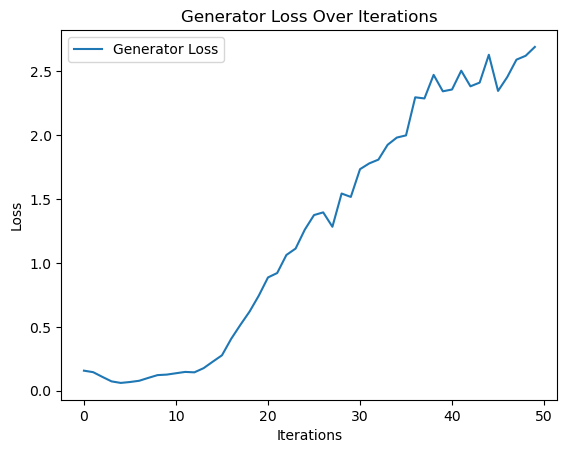

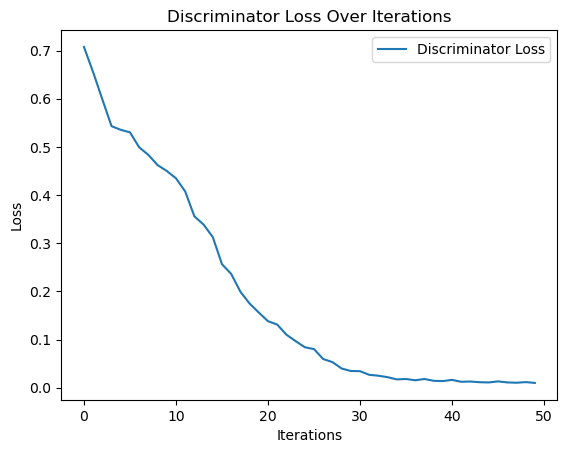

In [78]:
# Plot Generator Loss
plt.figure()
plt.plot(Gloss_list, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator Loss Over Iterations')
plt.legend()
plt.show()

# Plot Discriminator Loss
plt.figure()
plt.plot(Dloss_list, label='Discriminator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Discriminator Loss Over Iterations')
plt.legend()
plt.show()

In [79]:
imputed_list[9].shape

(2589, 12)

In [80]:
# converting the last imputed array to dataframe 
data_imputed_GAIN = pd.DataFrame(imputed_data[9][9], columns=data_gain_new.columns)

In [81]:
data_imputed_GAIN.head()

,PROV_CODE,DIST_CODE,Persons_killed,Persons_injured,Individuals_affected,Families_affected,Houses_damaged,Houses_destroyed,Latitude,Longitude,REGION,INC_TYPE
0,7.000000,701.000000,0.000000,0.000000,28.970284,5.58861,8.0,2.0,34.0,70.0,2.0,0.001481
1,15.000000,620.650391,3.000000,0.000000,21.000000,3.00000,0.0,3.0,37.0,70.0,3.0,0.001481
2,22.000000,2207.000000,0.359525,1.000000,19.000000,8.00000,3.0,5.0,34.0,65.0,1.0,0.001481
3,7.617163,723.139282,0.000000,0.623296,76.317436,219.00000,0.0,128.0,37.0,66.0,4.0,0.001481
4,18.033245,3101.000000,18.000000,9.000000,995.999939,150.00000,88.0,32.0,32.0,62.0,7.0,0.001481


In [82]:
#standardise imputed dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed_GAIN)

In [83]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(scaled_features)

# Calculate the silhouette score for clustering
silhouette_avg_GAIN = silhouette_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_GAIN}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.3988793774694123


In [84]:
# Calculate the Davies-Bouldin score for clustering
db_index_GAIN = davies_bouldin_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_GAIN}')

Davies-Bouldin Index: 1.126577723519262


# MIDA

In [85]:
from __future__ import division, print_function, absolute_import

In [86]:
def autoencoder_imputation(data_x, data_m, cat_index, num_index, all_levels, DAE_params, num_imputations):
    no, dim = data_x.shape
    # initial imputation
    data_x = initial_imputation(data_x, cat_index, num_index)

    data_train = np.array([])
    data_train_m = np.array([])
    ## encode cat
    if cat_index:
        data_cat = data_x[:, cat_index]
        data_cat_m = data_m[:, cat_index]
        data_cat_enc, data_cat_enc_miss = onehot_encoding(data_cat, data_cat_m, all_levels, has_miss=False)
        n_classes = list(map(lambda x: len(x), all_levels))
        data_train = data_cat_enc
        data_train_m = data_cat_enc_miss
    ## normalize num
    if num_index:
        data_num = data_x[:, num_index]
        data_num_m = data_m[:, num_index]
        data_num_norm, norm_parameters = normalization(data_num)
        data_train = np.concatenate([data_train, data_num_norm], axis=1) if data_train.size else data_num_norm
        data_train_m = np.concatenate([data_train_m, data_num_m], axis=1) if data_train_m.size else data_num_m

    # Training Parameters
    learning_rate = DAE_params["learning_rate"]
    num_steps1 = DAE_params["num_steps_phase1"]
    num_steps2 = DAE_params["num_steps_phase2"]
    batch_size = DAE_params["batch_size"]

    # Network Parameters
    num_input = data_train.shape[1]
    num_hidden_1 = data_train.shape[1] + DAE_params["theta"]  # 1st layer num features
    num_hidden_2 = data_train.shape[1] + 2 * DAE_params["theta"]  # 2nd layer num features (the latent dim)
    num_hidden_3 = data_train.shape[1] + 3 * DAE_params["theta"]

    # A random value generator to initialize weights.
    random_normal = tf.initializers.RandomNormal()

    weights = {
        'encoder_h1': tf.Variable(random_normal([num_input, num_hidden_1])),
        'encoder_h2': tf.Variable(random_normal([num_hidden_1, num_hidden_2])),
        'encoder_h3': tf.Variable(random_normal([num_hidden_2, num_hidden_3])),
        'decoder_h1': tf.Variable(random_normal([num_hidden_3, num_hidden_2])),
        'decoder_h2': tf.Variable(random_normal([num_hidden_2, num_hidden_1])),
        'decoder_h3': tf.Variable(random_normal([num_hidden_1, num_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(random_normal([num_hidden_1])),
        'encoder_b2': tf.Variable(random_normal([num_hidden_2])),
        'encoder_b3': tf.Variable(random_normal([num_hidden_3])),
        'decoder_b1': tf.Variable(random_normal([num_hidden_2])),
        'decoder_b2': tf.Variable(random_normal([num_hidden_1])),
        'decoder_b3': tf.Variable(random_normal([num_input])),
    }

    # Building the encoder
    @tf.function
    def encoder(x):
        x_noise = tf.nn.dropout(x, 0.5)
        layer_1 = tf.nn.tanh(tf.add(tf.matmul(x_noise, weights['encoder_h1']),
                                       biases['encoder_b1']))
        layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                       biases['encoder_b2']))
        layer_3 = tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                       biases['encoder_b3']))
        return layer_3

    # Building the decoder
    @tf.function
    def decoder(x):
        layer_1 = tf.nn.tanh(tf. add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        layer_3 = tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                         biases['decoder_b3'])
        col_index = 0
        empty_G_out = True
        # apply softmax to each categorical variable
        if cat_index:
            empty_G_out = False
            output = tf.nn.softmax(layer_3[:, :n_classes[0]])
            col_index = n_classes[0]
            for j in range(1, len(n_classes)):
                output = tf.concat(values=[output, tf.nn.softmax(layer_3[:, col_index:col_index + n_classes[j]])], axis=1)
                col_index += n_classes[j]
        # apply sigmoid to all numerical variables
        if num_index:
            out_num = tf.nn.sigmoid(layer_3[:, col_index:])
            output = tf.concat(values=[output, out_num], axis=1) if not empty_G_out else out_num
        return output

    # sum up loss for each categorical variable
    @tf.function
    def dae_loss(y_pred, y_true, mask):
        loss = 0
        current_ind = 0
        # categorical loss
        if cat_index:
            for j in range(len(n_classes)):
                mask_current = mask[:, current_ind:current_ind + n_classes[j]]
                y_pred_current = y_pred[:, current_ind:current_ind + n_classes[j]]
                y_true_current = y_true[:, current_ind:current_ind + n_classes[j]]
                loss += -tf.reduce_mean(
                    input_tensor=mask_current * y_true_current * tf.math.log(mask_current * y_pred_current + 1e-8)) / tf.reduce_mean(
                    input_tensor=mask_current)
                current_ind += n_classes[j]
        # numerical loss
        if num_index:
            mask_current = mask[:, current_ind:]
            y_pred_current = y_pred[:, current_ind:]
            y_true_current = y_true[:, current_ind:]
            loss += tf.reduce_mean((mask_current * y_true_current - mask_current * y_pred_current)**2) / tf.reduce_mean(mask_current)
        return loss

    # optimizer
    @tf.function
    def optimize_step(batch_x, batch_m):
        with tf.GradientTape() as g:
            y_hat = decoder(encoder(batch_x))
            l = dae_loss(y_hat, batch_x, batch_m)

        trainable_variables = list(weights.values()) + list(biases.values())

        gradients = g.gradient(l, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return l, y_hat

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate, decay=0.0)

    # multiple imputation
    imputed_list = []
    for l in range(num_imputations):
        # Start Training
        # Training phase 1
        loss_list = []
        pbar = tqdm(range(num_steps1))
        for i in pbar:
            # create mini batch
            indices = np.arange(no)
            np.random.shuffle(indices)
            for start_idx in range(0, no - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                batch_x = data_train[batch_idx, :]
                batch_m = data_train_m[batch_idx, :]

                # Run optimization op (backprop) and cost op (to get loss value)
                l, y_hat = optimize_step(batch_x, batch_m)
                pbar.set_description("loss at epoch {}: {:.3f}, phase 1".format(i, l))
                loss_list.append(l)

        imputed_data = decoder(encoder(data_train))
        imputed_data = data_train_m * data_train + (1 - data_train_m) * imputed_data

        # Training phase 2
        pbar = tqdm(range(num_steps2))
        for i in pbar:
            # create mini batch
            indices = np.arange(no)
            np.random.shuffle(indices)
            for start_idx in range(0, no - batch_size + 1, batch_size):
                batch_idx = indices[start_idx:start_idx + batch_size]
                batch_x = tf.gather(imputed_data, batch_idx, axis=0)
                batch_m = data_train_m[batch_idx, :]

                # Run optimization op (backprop) and cost op (to get loss value)
                l, y_hat = optimize_step(batch_x, batch_m)
                pbar.set_description("loss at epoch {}, phase 2: {:.3f}".format(i, l))
                loss_list.append(l)

        # get imputation
        imputed_data = decoder(encoder(imputed_data))
        imputed_data = data_train_m * data_train + (1 - data_train_m) * imputed_data

        # revert onehot and renormalize
        imputed = np.empty(shape=(no, dim))
        if cat_index:
            imputed_cat = imputed_data[:, :data_cat_enc.shape[1]]
            imputed_cat = onehot_decoding(imputed_cat, data_cat_enc_miss, all_levels, has_miss=False)
            imputed[:, cat_index] = imputed_cat
        if num_index:
            imputed_num = imputed_data[:, -data_num.shape[1]:]
            imputed_num = renormalization(imputed_num.numpy(), norm_parameters)
            imputed[:, num_index] = imputed_num
        imputed_list.append(imputed)
    return imputed_list, loss_list

In [87]:
data_mida = data_MCAR_df.copy()
cat_cols=  ['REGION','INC_TYPE']
num_cols = ['PROV_CODE', 'DIST_CODE','Persons_killed', 'Persons_injured', 'Individuals_affected', 'Families_affected','Houses_damaged', 'Houses_destroyed', 'Latitude', 'Longitude']
data_mida_new = data_mida[num_cols]
# concatinating numerical and categorical columns for the MIDA function
data_mida_new = pd.concat([data_mida_new, data_mida[cat_cols]],axis = 1)

In [88]:
# setting initial parameters for MIDA
DAE_parameters = {'learning_rate': 0.001,
                        'batch_size': 512,
                        'num_steps_phase1': 10,
                        'num_steps_phase2': 2,
                        'theta': 7}
num_index = list(range(0,6))
cat_index = list(range(6,11))

In [89]:
# creating data_x, data_m matrix for MIDA
# data_x = observed matrix, data_m = missing matrix
data_x = data_mida_new.values.astype(np.float32)
data_m = 1 - data_mida_new.isna().astype(np.float32).values

 # get all possible levels for categorical variable
all_levels = [np.unique(x) for x in data_x[:, cat_index].T]
all_levels_dict = dict(zip(data_mida_new.columns[cat_index], all_levels))

In [90]:
# samples and iterations for GAIN
rmse_ls = []
num_samples = 10
num_imputations = 10
imputed_data = {i: [] for i in range(num_samples)}

In [91]:
for i in range(num_samples):
    # Assuming data_x already has missing values
    miss_data_x = data_x.copy()
    data_m = 1 - np.isnan(miss_data_x).astype(np.float32)  # Mask for missing values

    # Initial imputation (e.g., using mean imputation)
    initial_imputated_data = np.nan_to_num(miss_data_x, nan=np.nanmean(miss_data_x, axis=0))

    # Perform the imputation using the model
    imputed_list, loss_list = autoencoder_imputation(initial_imputated_data, data_m, cat_index, num_index,
                                                           all_levels, DAE_parameters, num_imputations)

    # Store the imputed data in memory
    for l in range(num_imputations):
        imputed_data[i].append(imputed_list[l])

    print("{} done!".format(i))

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
loss at epoch 1, phase 2: 0.056: 100%|████████████| 2/2 [00:00<00:00,  2.81it/s]


0 done!


loss at epoch 1, phase 2: 0.054: 100%|████████████| 2/2 [00:00<00:00,  2.69it/s]


1 done!


loss at epoch 1, phase 2: 0.065: 100%|████████████| 2/2 [00:00<00:00,  2.72it/s]


2 done!


loss at epoch 1, phase 2: 0.070: 100%|████████████| 2/2 [00:00<00:00,  2.71it/s]


3 done!


loss at epoch 1, phase 2: 0.059: 100%|████████████| 2/2 [00:00<00:00,  2.75it/s]


4 done!


loss at epoch 1, phase 2: 0.063: 100%|████████████| 2/2 [00:00<00:00,  2.80it/s]


5 done!


loss at epoch 1, phase 2: 0.063: 100%|████████████| 2/2 [00:00<00:00,  2.88it/s]


6 done!


loss at epoch 1, phase 2: 0.067: 100%|████████████| 2/2 [00:00<00:00,  2.92it/s]


7 done!


loss at epoch 1, phase 2: 0.061: 100%|████████████| 2/2 [00:00<00:00,  2.93it/s]


8 done!


loss at epoch 1, phase 2: 0.066: 100%|████████████| 2/2 [00:00<00:00,  2.62it/s]


9 done!


In [92]:
# converting the last imputed array to dataframe 
data_imputed_mida = pd.DataFrame(imputed_data[9][9], columns=data_mida_new.columns)

In [93]:
#standardise imputed dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed_mida)

In [94]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(scaled_features)

# Calculate the silhouette score for clustering
silhouette_avg_MIDA = silhouette_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_MIDA}')

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for Season: 0.48355594077537617


In [95]:
# Calculate the Davies-Bouldin score for clustering
db_index_MIDA = davies_bouldin_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_MIDA}')

Davies-Bouldin Index: 1.1078327907326513


# K-means Imputation

In [96]:
data_MCAR_Kmeans = data_MCAR_df.copy()

In [97]:
# initially imputing with mean values
imputer = SimpleImputer(strategy='mean')

In [98]:
data_imputed_Kmeans = imputer.fit_transform(data_MCAR_Kmeans)

In [99]:
# function to iteratively impute missing values
k = 3
num_iterations = 10

for _ in range(num_iterations):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(data_imputed_Kmeans)

    # Impute missing values based on cluster means
    for cluster in range(k):
        cluster_indices = np.where(clusters == cluster)
        cluster_data = data_imputed_Kmeans[cluster_indices]

        # Calculate mean of each feature in the cluster
        cluster_means = np.nanmean(cluster_data, axis=0)

        # Impute missing values in the original data
        for i in cluster_indices[0]:
            for j in range(data_imputed_Kmeans.shape[1]):
                # Check if the original data had a missing value
                if np.isnan(data_MCAR_Kmeans.iloc[i, j]):  # Correctly access the DataFrame
                    data_imputed_Kmeans[i, j] = cluster_means[j]

data_imputed_Kmeans_df = pd.DataFrame(data_imputed_Kmeans, columns=data_MCAR_Kmeans.columns)

/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

In [100]:
#standardise imputed dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed_Kmeans_df)

In [101]:
# clustering with imputed dataset
kmeans_fixed_season = KMeans(n_clusters=4, random_state=42)
kmeans_fixed_season.fit(scaled_features)

# Calculate the silhouette score for clustering
silhouette_avg_Kmeans = silhouette_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Silhouette Score for Season: {silhouette_avg_Kmeans}')

Silhouette Score for Season: 0.43780450383347413


/Users/anmolahuja/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [102]:
# Calculate the Davies-Bouldin score for clustering
db_index_Kmeans = davies_bouldin_score(scaled_features, kmeans_fixed_season.labels_)
print(f'Davies-Bouldin Index: {db_index_Kmeans}')

Davies-Bouldin Index: 0.894799211731179
